<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ временного ряда</a></span><ul class="toc-item"><li><span><a href="#Разделим-выборки-на-треин-и-тест." data-toc-modified-id="Разделим-выборки-на-треин-и-тест.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделим выборки на треин и тест.</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prophet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [6]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 10.7 MB/s eta 0:00:02
   ---- ----------------------------------- 1.6/13.3 MB 16.6 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/13.3 MB 22.2 MB/s eta 0:00:01
   ---------- ----------------------------- 3.6/13.3 MB 8.5 MB/s eta 0:00:02
   ----------------- ---------------------- 5.8/13.3 MB 12.4 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 14.6 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 14.6 MB/s eta 0:0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import datetime
from sklearn.model_selection import ParameterGrid

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from prophet import Prophet

In [2]:
df = pd.read_csv('./taxi.csv', index_col='datetime', parse_dates=['datetime'])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.sort_index(inplace=True)

display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Проверим, что данные представлены за каждый час каждого дня с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.

In [3]:
pd.date_range(df.index.min(), df.index.max(), freq="1H").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='H')

Пропущенных часов нет. Добавим признаки, которые можно извлечь из даты. Они пригодятся как для анализа, так и для построения моделей.

In [3]:
def create_date_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    
    return df

In [4]:
df = create_date_features(df, 12, 5)
df.head(5)

,num_orders,day,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,3,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Анализ временного ряда

Построим гистограмму колиечства заказов, чтобы оценить частоту заказов такси в час.

<Axes: xlabel='num_orders', ylabel='Count'>

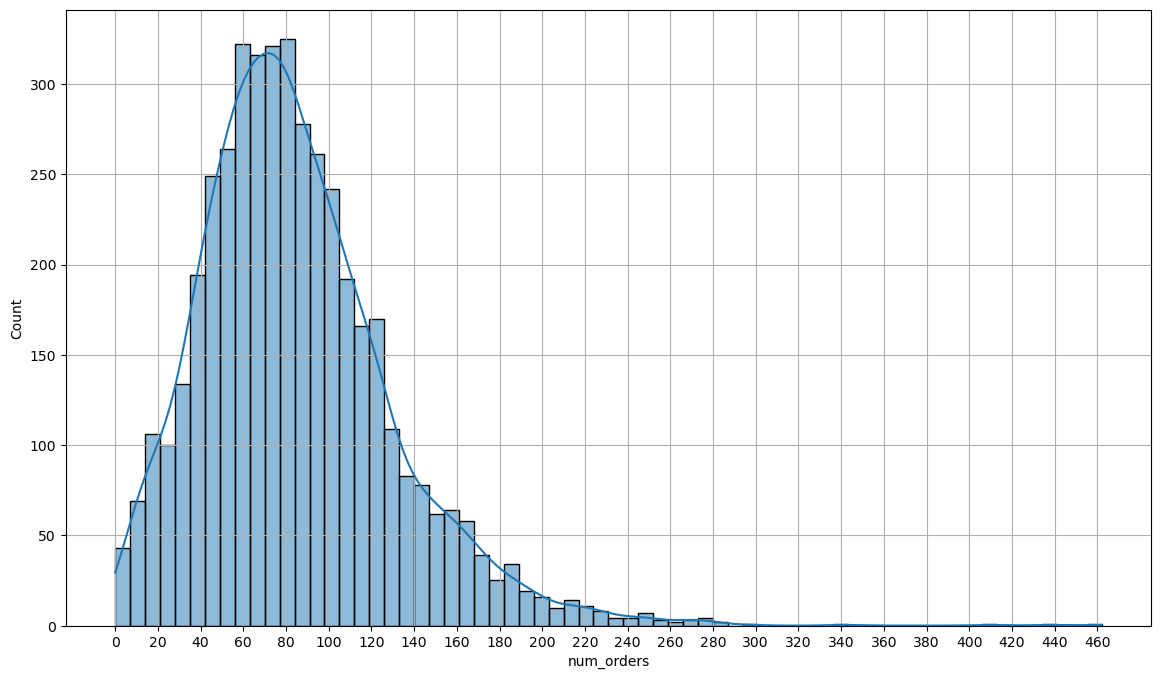

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.xticks(np.arange(0, 480, step=20))
plt.grid()
sns.histplot(data = df['num_orders'], kde = True, bins=int(df.shape[0]**0.5))

Распределение скошено вправо, это выглядит правдоподобно, особенно учитывая, что датасет содержит данные заказов из аэропорта, а не обычного жилого района. Логично, что меньше 10 заказов в час из аэропорта бывает редко, а часы с необычано большим количеством заказов иногда случаются.

Построим диаграмму размаха, чтобы оценить распределение и выбросы.

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

<Axes: >

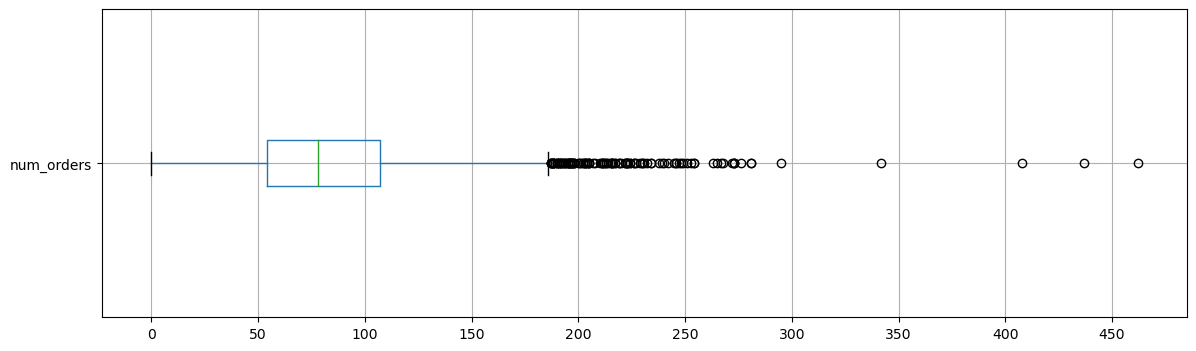

In [7]:
display(df['num_orders'].describe())

fig, ax = plt.subplots(figsize=(14, 4))
plt.xticks(np.arange(0, 500, step=50))

df.boxplot(column='num_orders', vert=False)

Медианное значение - 78 заказов в час. Соглассно диаграмме выбросы это от 186 заказов в час. Рассмотрим значения, которые на диаграмме являются выбросами.

array([[<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day_of_week'}>]], dtype=object)

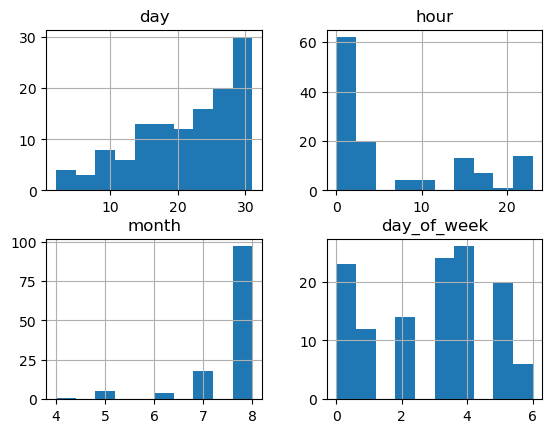

In [8]:
outliers = df[df['num_orders'] >= 186]

outliers[['day', 'hour', 'month', 'day_of_week']].hist()

0.8% экстремально больних значений относятся к апрелю, 4% к маю, 3.2% к июню, 14.4% к июлю и 77.6% к августу. Посмотрим в какие дни по месяцам были эти значения. Если они сосредоточены в отдельных днях, то это могут быть праздники или выбросы. Их надо убрать или поменить. Если это разные дни, то это постепенное увеличение заказов, связанное с трендом/сезонностью, и с этими даннми ничего не надо делать.

In [9]:
for month in range(4, 9):
    print('month:', month)
    display(outliers[outliers['month']==month].groupby('day').count())

month: 4


,num_orders,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
day,,,,,,,,,,,,,,,,,
24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


month: 5


,num_orders,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
day,,,,,,,,,,,,,,,,,
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
18,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
19,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
28,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


month: 6


,num_orders,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
day,,,,,,,,,,,,,,,,,
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


month: 7


,num_orders,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
day,,,,,,,,,,,,,,,,,
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
16,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
19,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
21,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


month: 8


,num_orders,hour,month,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
day,,,,,,,,,,,,,,,,,
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
11,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
13,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
14,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
15,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


По-видимому, это не выбросы, а тренд или сезонность - количество заказов увеличивается со временем.

Построим графики среднего количество заказов за час для каждого дня для выбранного месяца. Проанализируем, зависит ли среднее количество заказов в час от дня недели.

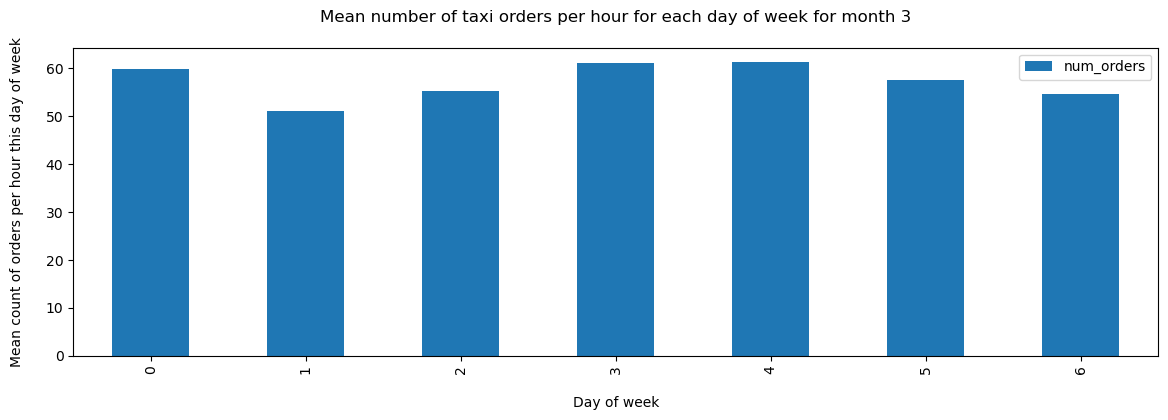

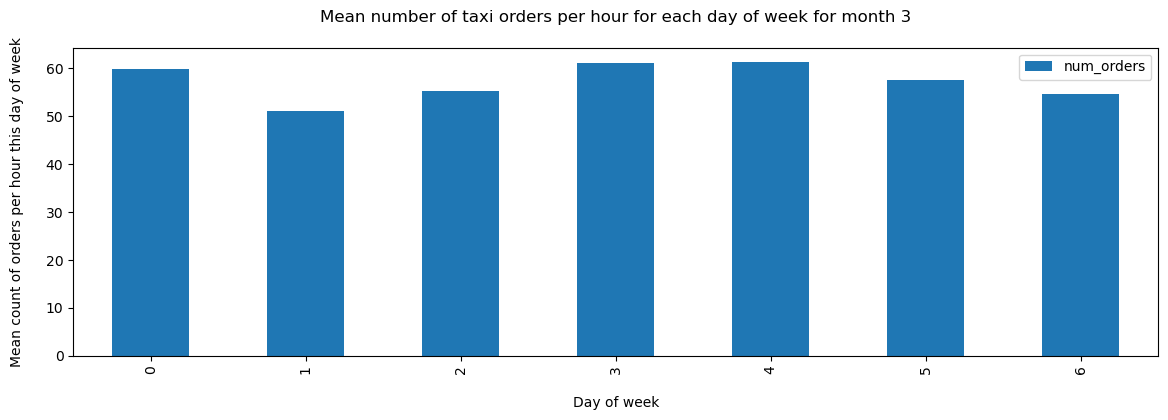

top 3 of month 8
day_of_week
0    144.916667
4    135.075000
3    129.133333
Name: num_orders, dtype: float64
bottom 3 of month 8
day_of_week
6    115.968750
1    120.541667
5    123.052083
Name: num_orders, dtype: float64
top 3 of month 8
day_of_week
0    144.916667
4    135.075000
3    129.133333
Name: num_orders, dtype: float64
bottom 3 of month 8
day_of_week
6    115.968750
1    120.541667
5    123.052083
Name: num_orders, dtype: float64


In [10]:
# Создание функции для построения графика
def plot_mead_orders_per_hour_of_days_of_week_for_month(month):
    df[df['month'] == month].pivot_table(index = 'day_of_week', aggfunc='mean', values = 'num_orders').plot(y ='num_orders', kind = 'bar', figsize=(14, 4))
    plt.xlabel('\nDay of week')
    plt.ylabel('Mean count of orders per hour this day of week\n')
    plt.title(f'Mean number of taxi orders per hour for each day of week for month {month}\n')
    plt.show()
    
def print_stat_info(month1):
    print(f'top 3 of month {month}')
    print(df[df['month'] == month].groupby('day_of_week')['num_orders'].mean().nlargest(3))
    
    print(f'bottom 3 of month {month}')
    print(df[df['month'] == month].groupby('day_of_week')['num_orders'].mean().nsmallest(3))
    
# Создание выпадающего списка выбора месяца
choose_month_dropdown_1 = widgets.Dropdown(options=[3, 4, 5, 6, 7, 8], description="Select month")
choose_month_dropdown_2 = widgets.Dropdown(options=[3, 4, 5, 6, 7, 8], description="Select month")

# Создание кнопки для построения графика
plot_button_month = widgets.Button(description='Plot')

# Отображение элементов управления
display(widgets.HBox((choose_month_dropdown_1, choose_month_dropdown_2, plot_button_month)))

# Создание функции-обработчика нажатия на кнопку
def on_button_click(b):
    clear_output()
    
    display(widgets.HBox((choose_month_dropdown_1, choose_month_dropdown_2, plot_button_month)))
    plot_mead_orders_per_hour_of_days_of_week_for_month(choose_month_dropdown_1.value)
    plot_mead_orders_per_hour_of_days_of_week_for_month(choose_month_dropdown_2.value)
    
    print_stat_info(choose_month_dropdown_1.value)
    print_stat_info(choose_month_dropdown_2.value)

# Назначение функции-обработчика нажатия на кнопку
plot_button_month.on_click(on_button_click)

Наименьшее среднее количество заказов в час каждый месяц во вторник и воскресенье. В топ-3 дня недели по среднему количеству заказов в час всегда входит пятница и почти все время сходит понедельник.

Посмотрим, как меняется количество заказов в час в течение суток.

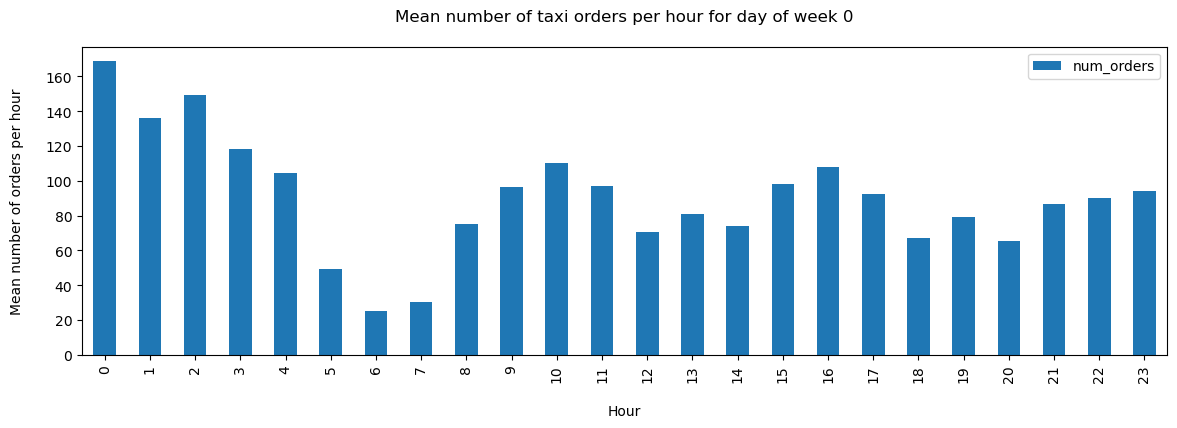

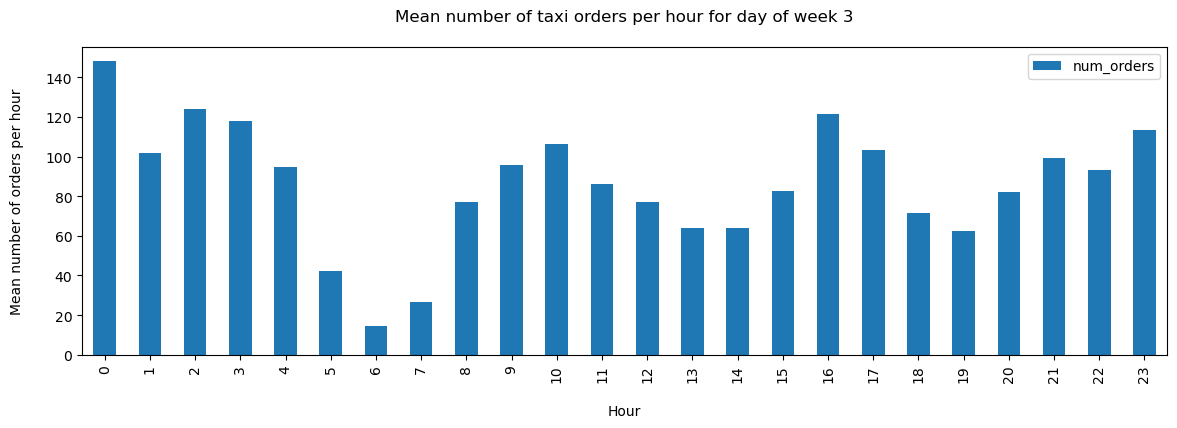

top 3 of day_of_week 0
hour
0    168.576923
2    149.076923
1    135.923077
Name: num_orders, dtype: float64
bottom 3 of day_of_week 0
hour
6    25.423077
7    30.192308
5    49.423077
Name: num_orders, dtype: float64
top 3 of day_of_week 0
hour
0    168.576923
2    149.076923
1    135.923077
Name: num_orders, dtype: float64
bottom 3 of day_of_week 0
hour
6    25.423077
7    30.192308
5    49.423077
Name: num_orders, dtype: float64


In [11]:
# Создание функции для построения графика
def plot_mean_orders_per_hour_for_day_of_week(day_of_week):
    df[df['day_of_week'] == day_of_week].pivot_table(index = 'hour', aggfunc='mean', values = 'num_orders').plot(y ='num_orders', kind = 'bar', figsize=(14, 4))
    plt.xlabel('\nHour')
    plt.ylabel('Mean number of orders per hour\n')
    plt.title(f'Mean number of taxi orders per hour for day of week {day_of_week}\n')
    plt.show()
    
def print_stat_info_day_of_week(day_of_week):
    print(f'top 3 of day_of_week {day_of_week}')
    print(df[df['day_of_week'] == day_of_week].groupby('hour')['num_orders'].mean().nlargest(3))
    
    print(f'bottom 3 of day_of_week {day_of_week}')
    print(df[df['day_of_week'] == day_of_week].groupby('hour')['num_orders'].mean().nsmallest(3))
    
# Создание выпадающего списка выбора месяца
choose_day_of_week_dropdown_1 = widgets.Dropdown(options=[0, 1, 2, 3, 4, 5, 6], description="Select day")
choose_day_of_week_dropdown_2 = widgets.Dropdown(options=[0, 1, 2, 3, 4, 5, 6], description="Select day")

# Создание кнопки для построения графика
plot_button_day_of_week = widgets.Button(description='Plot')

# Отображение элементов управления
display(widgets.HBox((choose_day_of_week_dropdown_1, choose_day_of_week_dropdown_2, plot_button_day_of_week)))

# Создание функции-обработчика нажатия на кнопку
def on_button_day_of_week_click(b):
    clear_output()
    
    display(widgets.HBox((choose_day_of_week_dropdown_1, choose_day_of_week_dropdown_2, plot_button_day_of_week)))
    plot_mean_orders_per_hour_for_day_of_week(choose_day_of_week_dropdown_1.value)
    plot_mean_orders_per_hour_for_day_of_week(choose_day_of_week_dropdown_2.value)
    
    print_stat_info_day_of_week(choose_day_of_week_dropdown_1.value)
    print_stat_info_day_of_week(choose_day_of_week_dropdown_1.value)

# Назначение функции-обработчика нажатия на кнопку
plot_button_day_of_week.on_click(on_button_day_of_week_click)

Графики за каждый день имеют очень похожую форму. Много заказов в 0-2, снижение в 5-6, снова вверх в 10-11, вниз в 12-13, вверх в 16-17, вниз в 18-19 и вверх в 22-23. Всегда много заказов в ночное время, вероятно, потому что в ночное время из аэропортов хуже ходит общественный транспорт и в это время люди не просят кого-то из знакомых забрать из аэропорта. Еще это может быть связано с развозом по домам сотрудников аэропорта в позднее время.

Построим графики временного ряда.

In [13]:
def plot_time_series(df):
    df['num_orders'].plot(figsize=(14, 7))
    
    decomposed = seasonal_decompose(df['num_orders'])

    plt.figure(figsize=(14, 18))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)

    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)

    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()    

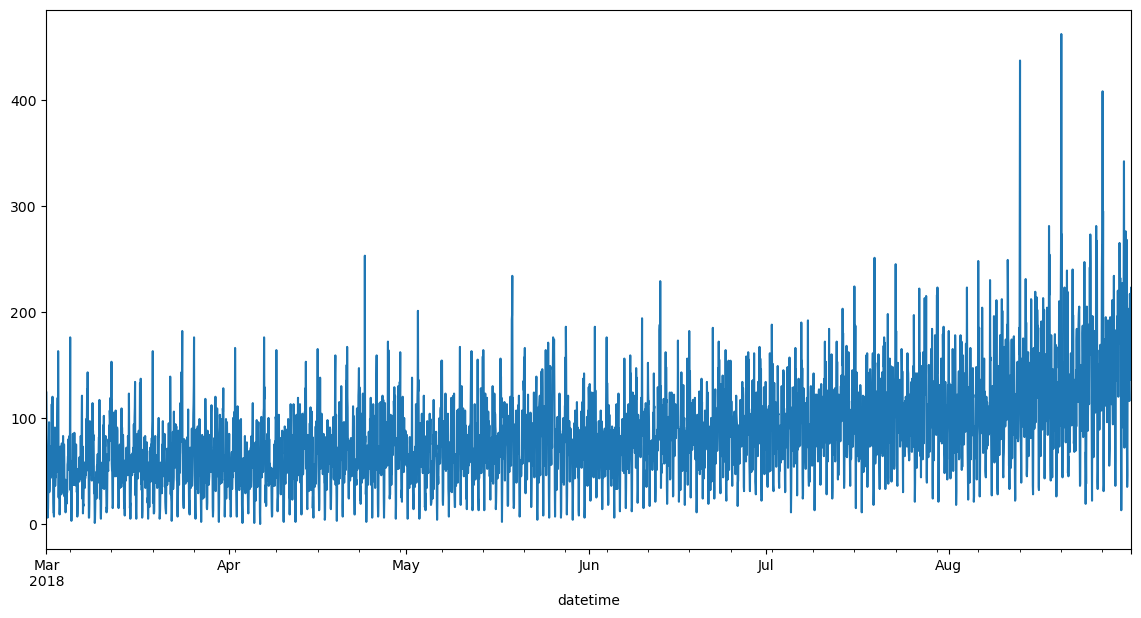

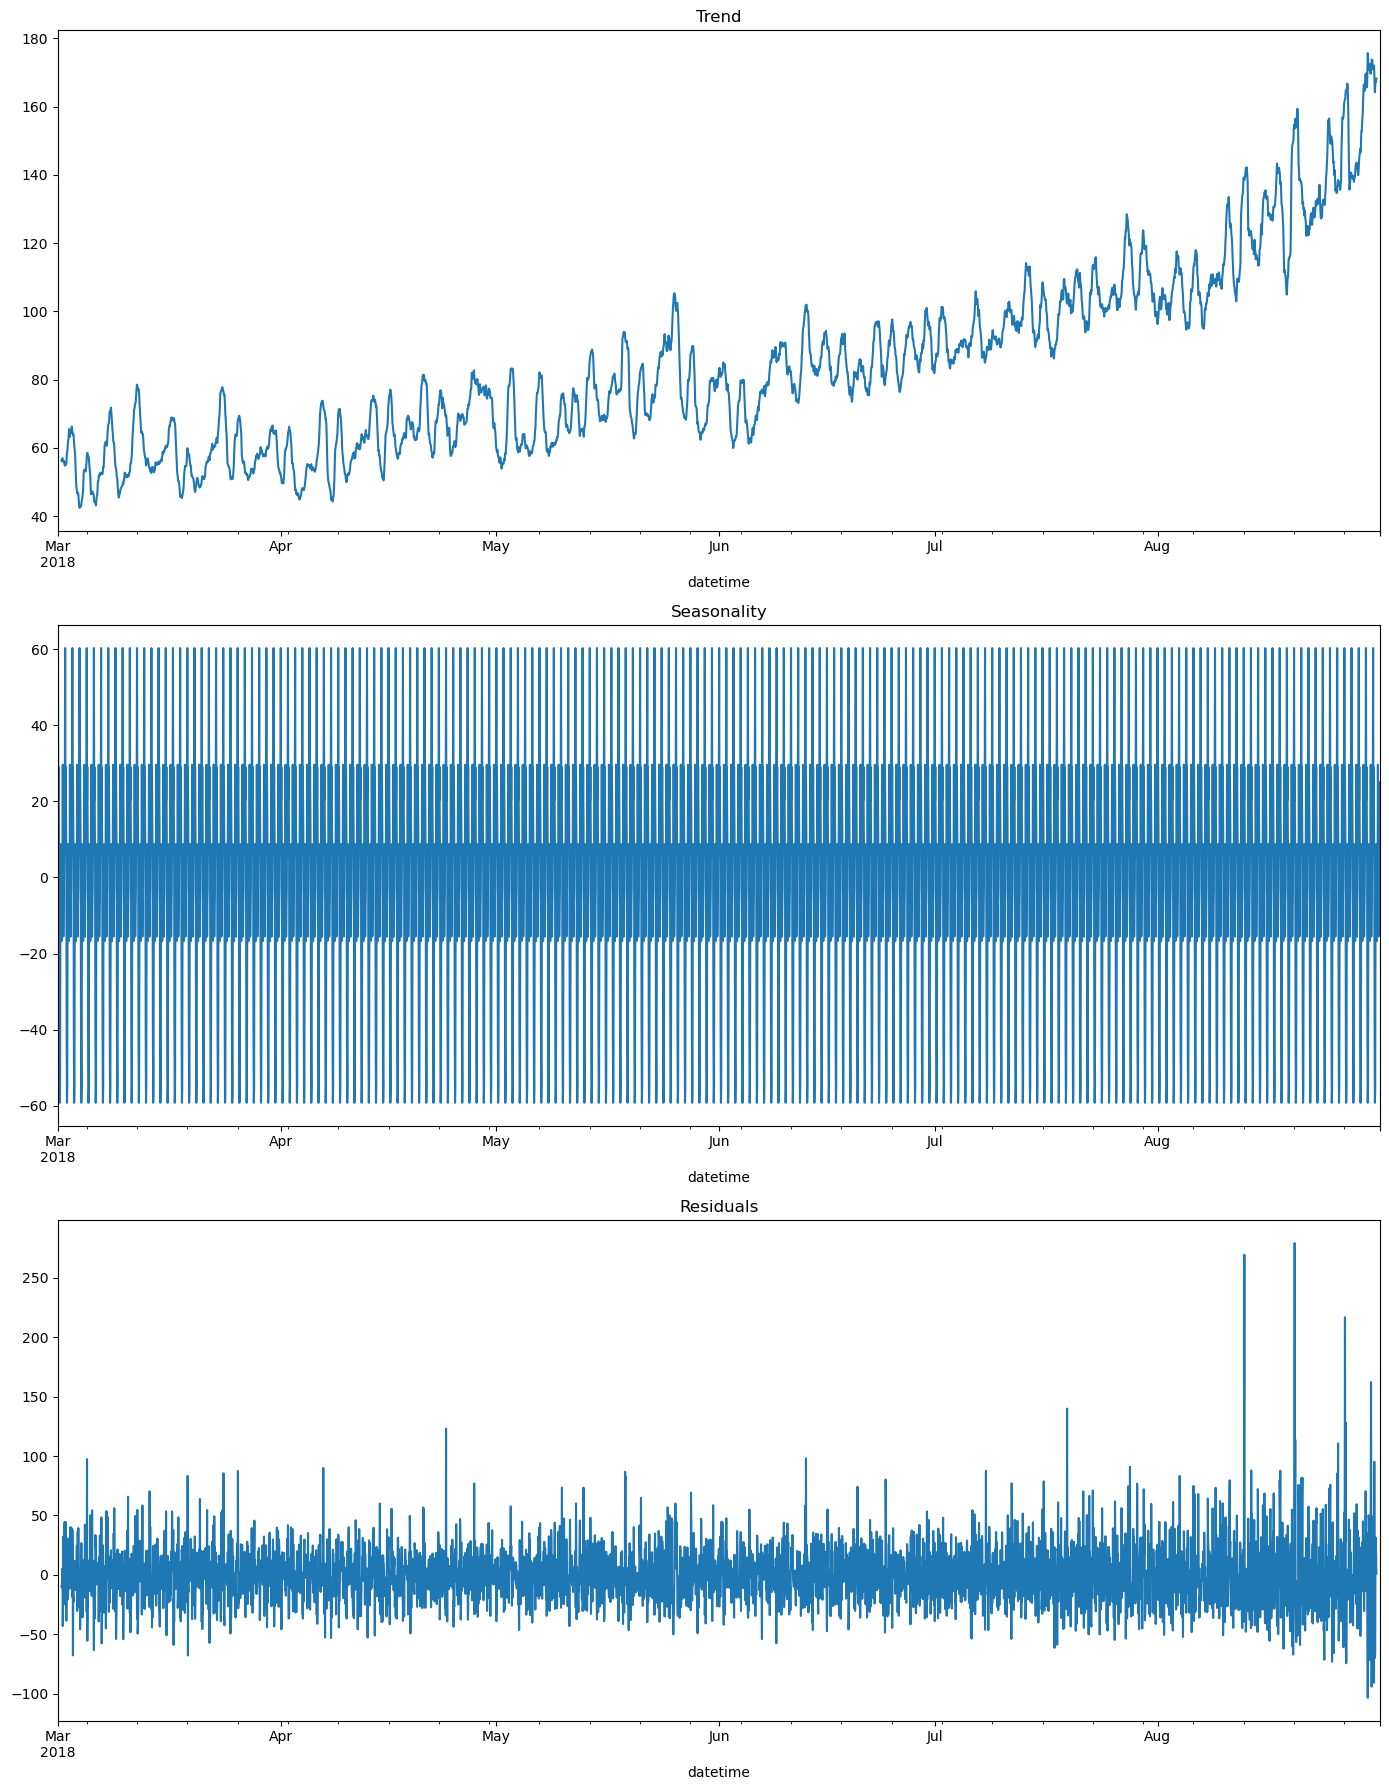

In [14]:
plot_time_series(df)

График тренда растет. Стандартное отклонение остатка незначительно меняется, под конец увеличивается, виднеется несколько сильных выбросов.


График сезонности в таком масштабе не информативен. Посмотрим графики за разные промежутки времени.

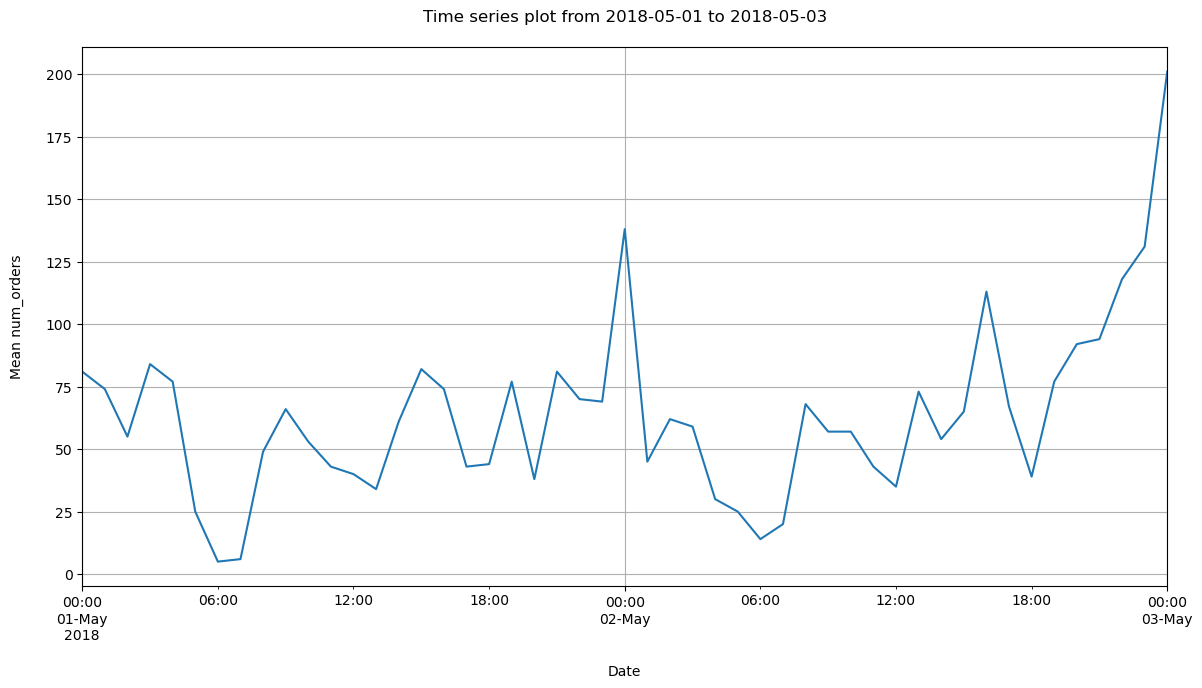

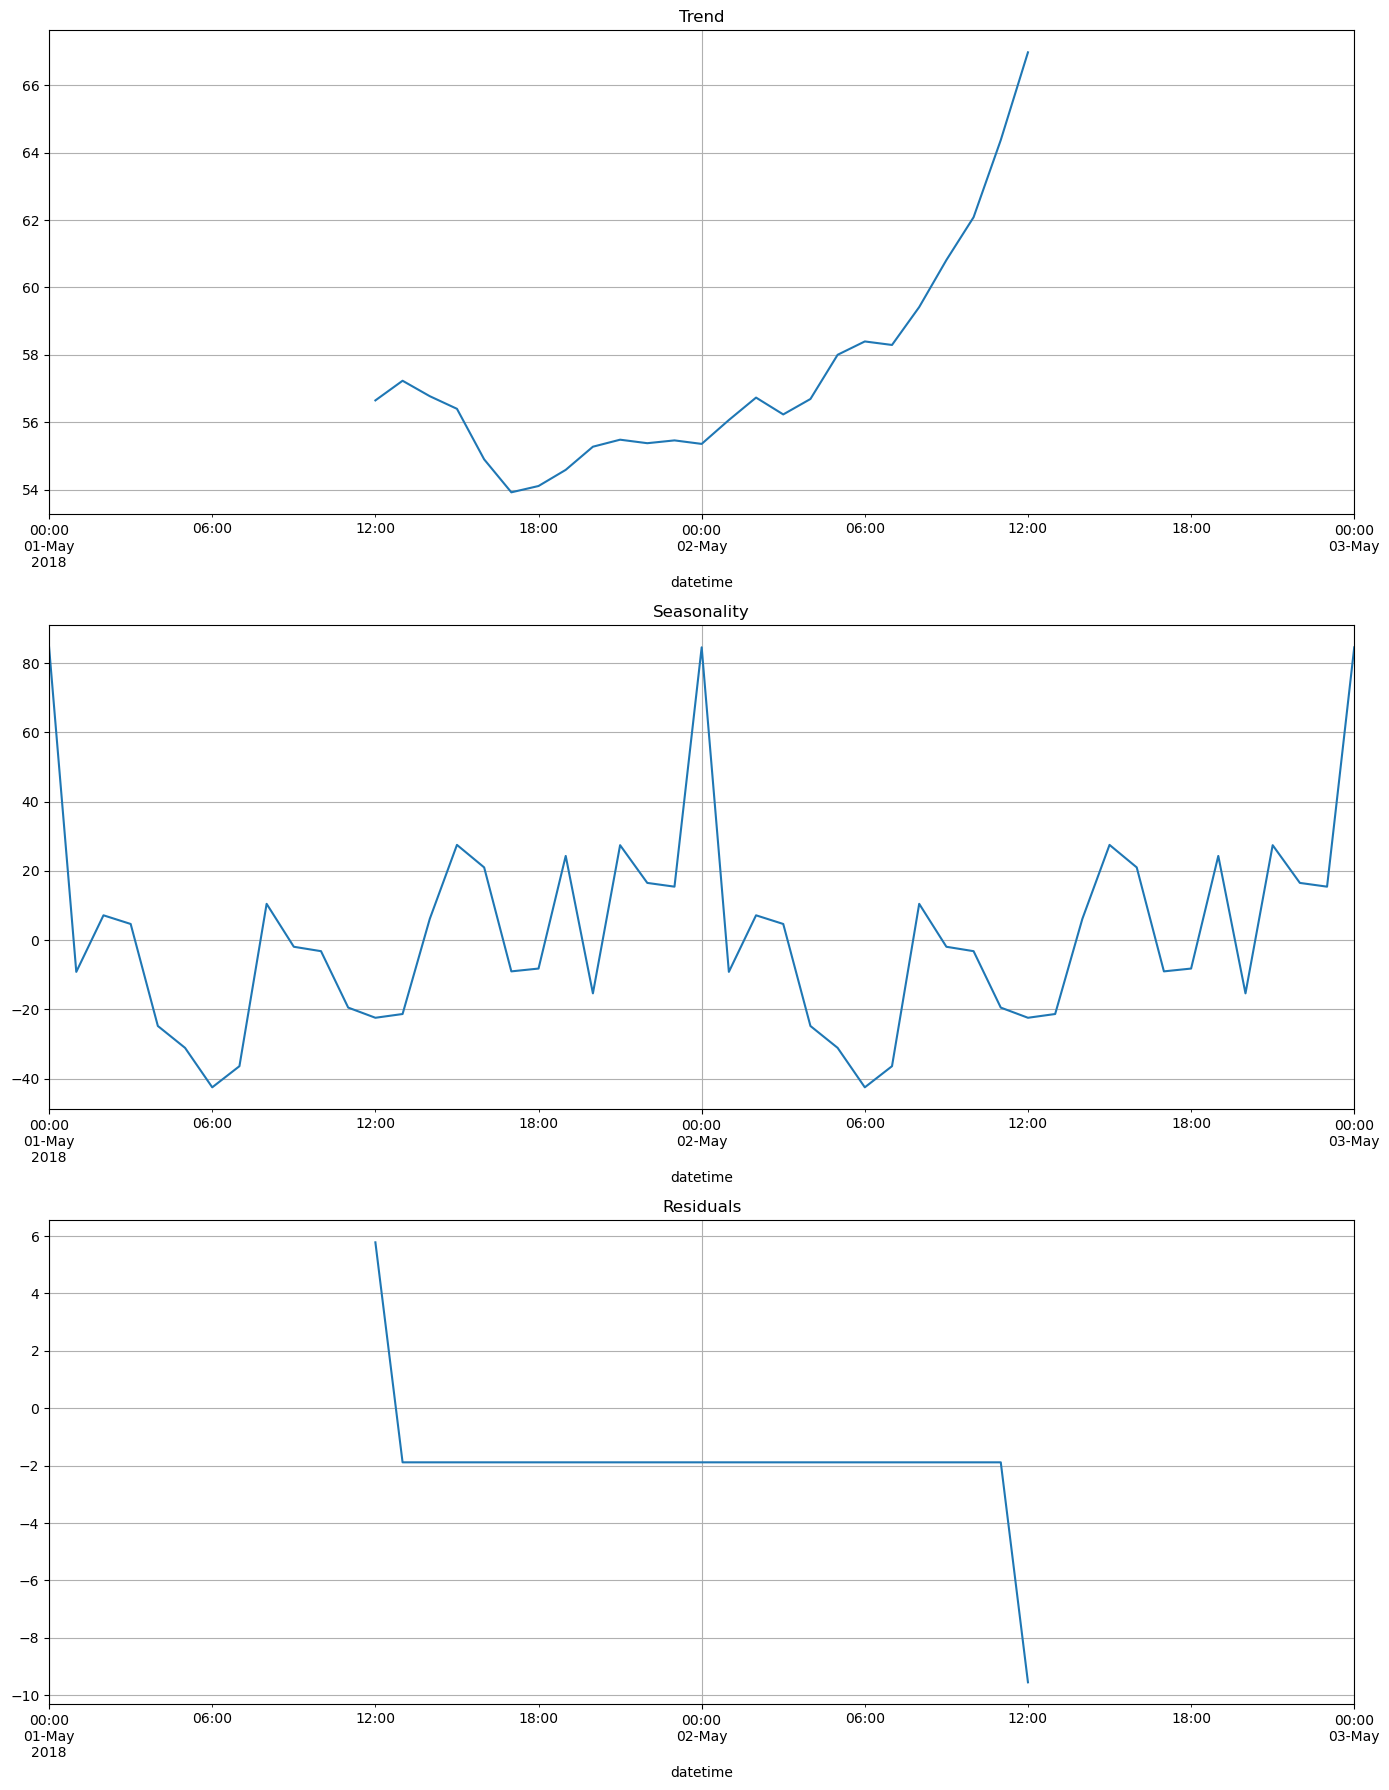

In [16]:
# Создание функции для построения графика
def plot_time_series_for_month(date_start, date_end):
    df[date_start:date_end]['num_orders'].plot(figsize=(14, 7))
    plt.xlabel('\nDate')
    plt.ylabel('Mean num_orders\n')
    plt.title(f'Time series plot from {date_start} to {date_end}\n')
    plt.grid()
    plt.show()
    
def plot_time_series_decomposed(date_start, date_end):
    decomposed = seasonal_decompose(df[date_start:date_end]['num_orders'])

    plt.figure(figsize=(14, 18))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.grid()
    plt.subplot(312)

    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.grid()
    plt.subplot(313)

    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.grid()
    plt.tight_layout()
    

# Создание кнопки для построения графиков
plot_button_month = widgets.Button(description='Plot')

# Создание
date_picker_start = widgets.DatePicker(description='Pick a Date', disabled=False, value = datetime.date(2018,5,1))

date_picker_end = widgets.DatePicker(
    description='Pick a Date',
    disabled=False,
    value = datetime.date(2018,5,3)
)

# Отображение элементов управления
display(widgets.HBox((date_picker_start, date_picker_end, plot_button_month)))

# Создание функции-обработчика нажатия на кнопку
def on_button_click(b):
    clear_output()
    
    display(widgets.HBox((date_picker_start, date_picker_end, plot_button_month)))
    
    plot_time_series_for_month(date_picker_start.value, date_picker_end.value)
    plot_time_series_decomposed(date_picker_start.value, date_picker_end.value)

# Назначение функции-обработчика нажатия на кнопку
plot_button_month.on_click(on_button_click)

График сезонности в рамках нескольких дней подтвердил сезонность в рамках суток. График сезонности выглядит стационарным, но общий график ряда не выглядит стационарным из-за увеличивающихся среднего значения и стандартного отклонения. Но для моделей, которым мы будем рассматривать, не требуется стационарность ряда.

Попробуем разные модели и сравним их эффективность:
- SARIMA (Seasonal ARIMA) представляет собой расширение модели ARIMA, подходит для временных рядов с сезонностью в данных;
- Prophet - новая модель, разработанная Facebook. Она хорошо подходит для прогнозирования временных рядов с сильной сезонностью.

### Разделим выборки на треин и тест.

In [6]:
df = df.dropna()

split_date_train = int(0.8 * len(df))
split_date_valid = int(0.9 * len(df))

# Разделение данных
df_train = df.iloc[:split_date_train]
df_valid = df.iloc[split_date_train:split_date_valid]
df_test = df.iloc[split_date_valid:]

### SARIMA

In [8]:
# Подготовка данных
df_train_endog = df_train['num_orders']
df_train_exog = df_train.drop(columns=['num_orders'])

df_valid_endog = df_valid['num_orders']
df_valid_exog = df_valid.drop(columns=['num_orders'])

# Обучение финальной SARIMAX модели на обучающей выборке
sarimax = SARIMAX(
    df_train_endog, exog=df_train_exog,
    order=(5, 1, 0),
    seasonal_order=(1, 0, 0, 24),
    seasonal=True, m=24
)

sarimax_results = sarimax.fit(method='bfgs')

forecast_steps = len(df_valid_endog)
forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=df_valid_exog)

# Расчет RMSE
rmse_sarimax = mean_squared_error(df_valid_endog, forecast.predicted_mean, squared=False)
print(f"SARIMAX RMSE: {rmse_sarimax}")

         Current function value: 4.644879
         Iterations: 23
         Function evaluations: 80
         Gradient evaluations: 69


C:\Users\Maria\anaconda3\envs\praktikum\envs\ds_practicum_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX RMSE: 85.22259524980788


In [27]:
# Подготовка данных
df_train_endog = df_train['num_orders']
df_train_exog = df_train.drop(columns=['num_orders'])

# Кросс-валидация с использованием auto_arima
cv = pm.model_selection.SlidingWindowForecastCV(window_size=500, step=50)

model_sarimax = pm.auto_arima(
    df_train_endog, exogenous=df_train_exog,
    seasonal=True, m=24,  # сезонность с периодом в 24 часа
    suppress_warnings=True,
    cv=cv
)

# Вывод оптимальных гиперпараметров
print(model_sarimax.get_params())

{'maxiter': 50, 'method': 'lbfgs', 'order': (5, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 0, 24), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


In [21]:
# Подготовка данных
df_valid_endog = df_valid['num_orders']
df_valid_exog = df_valid.drop(columns=['num_orders'])

# Обучение финальной SARIMAX модели на обучающей выборке
sarimax = SARIMAX(
    df_train_endog, exog=df_train_exog,
    order=model.get_params()['order'],
    seasonal_order=model.get_params()['seasonal_order'],
    seasonal=True, m=24,
)

sarimax_results = sarimax.fit()

forecast_steps = len(df_valid_endog)
forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=df_valid_exog)

# Расчет RMSE
rmse_sarimax = mean_squared_error(df_valid_endog, forecast.predicted_mean, squared=False)
print(f"SARIMAX RMSE: {rmse_sarimax}")

C:\Users\Maria\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX RMSE: 92.49149890031994


Слишком большая ошибка.

### Prophet

In [32]:
# Подготовка датафрейма
df_train_prophet = df_train.rename(columns={"num_orders": "y"})
df_train_prophet['ds'] = df_train_prophet.index

df_valid_prophet = df_valid.rename(columns={"num_orders": "y"})
df_valid_prophet['ds'] = df_valid_prophet.index

# Создание списка для хранения результатов перебора
results = []

# Определение сетки параметров для перебора
param_grid = {
    'seasonality_prior_scale': [0.01, 20.0, 0.10],
    'changepoint_prior_scale': [0.001, 0.5, 0.01]
}

# Перебор комбинаций параметров
for params in ParameterGrid(param_grid):
    # Создание объекта Prophet с текущими параметрами
    model = Prophet(**params, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, growth='linear')
    
    for column in df_train_prophet.columns:
        if column not in ['ds', 'y']:
            model.add_regressor(column)
            
    model.add_seasonality(name='daily', period=24, fourier_order=5)

    model.fit(df_train_prophet)

    forecast = model.predict(df_valid_prophet)

    rmse = mean_squared_error(df_valid_prophet['y'], forecast['yhat'], squared=False)

    results.append({'params': params, 'rmse': rmse})


best_params = min(results, key=lambda x: x['rmse'])['params']

print("Best Parameters:", best_params)
print("Best RMSE Prophet:", min(results, key=lambda x: x['rmse'])['rmse'])

17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0}
Best RMSE Prophet: 33.542225047133904


Гораздо лучше метрика у модели Prophet. Проверим ее на тестовой выборке.

## Тестирование

In [34]:
df_test_prophet = df_test.rename(columns={"num_orders": "y"})
df_test_prophet['ds'] = df_test.index

df_train_valid_prophet = pd.concat([df_train_prophet, df_valid_prophet])

best_model_prophet = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, growth='linear', changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
    
for column in df_test_prophet.columns:
    if column not in ['ds', 'y']:
        best_model_prophet.add_regressor(column)

best_model_prophet.add_seasonality(name='daily', period=24, fourier_order=5)

best_model_prophet.fit(df_train_valid_prophet)
forecast = best_model_prophet.predict(df_test_prophet)

rmse_prophet_on_test = mean_squared_error(df_test_prophet['y'], forecast['yhat'], squared=False)
print('rmse_prophet_on_test:', rmse_prophet_on_test)

17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing


rmse_prophet_on_test: 44.38573571240548


## Вывод

В рамках работы:
- Был проведен анализ временного ряда. Обнаружена суточная сезонность, выявлены пиковые часы заказов такси;
- Подобраны модели, подходящие для прогнозирования нестационарного временного ряда с сезонностью и трендом;
- Обучены модели SARIMAX и Prophet, выбрана лучшая Prophet;
- RMSE модели Prophet на тестовой выборке 44.39.